In [691]:
#IMPORT LIST OF FIRMS FOR ANALYSIS

import pandas as pd

path = '/Users/thorhauberg/Dropbox/Analyse af virksomheder/Resources/Firms_to_analyze.csv'

firms = pd.read_csv(path)    

firmUrls = firms.iloc[:,1]
firmName = firms.iloc[:,2]
NumberOfFirms = len(firmUrls)
print(str(NumberOfFirms) + ' firms loaded')

# ENSURE CORRECT URL'S

count = 0 # remember to row number

for url in firms['url']:
    if 'http' in url:
        count += 1
    elif 'www' in url:
        firms.iloc[count,1] = 'http://' + str(url)
        count += 1      
    else:
        firms.iloc[count,1] = 'http://www.' + str(url)
        count += 1
        
#print(firms['url'])
#print(firms.iloc[1:50,:])

#  when testing:
#firmUrls = firmUrls[80:120]
# SET COUNTER TO 80
#print(firmUrls)

5574 firms loaded


In [692]:
# getting the text from the website
import requests # to access the webpage
import re

from bs4 import BeautifulSoup
from bs4.element import Comment

from IPython.display import clear_output, display # used for percent complete
import datetime # for the file-name
import time # for the file-name

# for the filename
now = datetime.datetime.now()
date = str(now.year) + '-' + str(now.month) + '-' + str(now.day)
folder_path = '/Users/thorhauberg/Dropbox/Analyse af virksomheder/Website source code/'

# to handle pages that rejects GET requests without user-agent
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}

# various counters
countExceptions = 0
countSuccess = 0 
countProgress = 0 
errorLog = []

# functions to get the clean text from the sauce
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)
    return u" ".join(t.strip() for t in visible_texts)

# process the text further
def pre_process(text):
# lowercase
    text=text.lower()
#remove tags
    text=re.sub("<!--?.*?-->","",text)
# remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    return text

for firm in firmUrls:
    try:
        # get the webpages source code
        result = requests.get(firm, timeout=20, headers=headers)
        src = result.text
        sauce_src = text_from_html(src)
        
        # further processing the text
        clean_src = pre_process(sauce_src)
        
        # check if scrape is long enough to be a good scrape
        if len(clean_src) < 1000:
            shortScrape = str(firms.iloc[countProgress,2]) + ' length: ' + str(len(clean_src))
            errorLog.append(shortScrape)
        
            # get more text of text scrape to short
            try:
                soup = BeautifulSoup(src)
                links = soup.findAll('a', href=True)
                for link in links:
                    href = link['href']
                    if 'https://' in href:
                        result = requests.get(href, timeout=20, headers=headers)
                        src = result.text
                        sauce_src = text_from_html(src)
                        clean_src = clean_src + pre_process(sauce_src)
                        
            except requests.exceptions.RequestException as e:
                    continue

        # construct file name and save in 'Website source code'
        firm_name = firms.iloc[countProgress,2]
        file_path = folder_path + firm_name + '_scrape_' + date + '.txt'
        file = open(file_path, 'w')
        file.write(clean_src)
        file.close()
        
        countSuccess = countSuccess + 1

    except requests.exceptions.RequestException as e:
        countExceptions = countExceptions + 1
        errorLog.append(e)
        countProgress = countProgress + 1
        continue 
    
    countProgress = countProgress + 1
    clear_output(wait=True)
    print(round(countProgress/NumberOfFirms*100,2), ' percent complete')    


print(str(countExceptions) + ' exceptions')
print(str(countSuccess) + ' success')

#save error log 
file_path = folder_path + date + '_ErrorLog.txt'
logFile = open(file_path, 'w')
logFile.write(str(errorLog))
logFile.close()

#print(*errorLog, sep='\n')
# execution time for 5.5K doc approximately 3 hours

99.82  percent complete
1015 exceptions
4550 success


In [839]:
# BUILD THE CORPUS FROM LOADED FILES
import glob
import pandas as pd


# get path to all docs
path = '/Users/thorhauberg/Dropbox/Analyse af virksomheder/Website source code/*.txt'
all_docs = glob.glob(path)

# build dataframe with all docs

corpus = pd.DataFrame(columns=['firm','data'])
counter = 0 

for doc in all_docs:
    with open(doc, 'r') as doc_file:
        # get firm name
        clean_path = doc.replace('/Users/thorhauberg/Dropbox/Analyse af virksomheder/Website source code/', '')
        clean_path = clean_path.split('_', 1)[0]
        # get data
        doc_data = doc_file.read()
        doc_string = str(doc_data)
        # update corpus with firm & data
        corpus.loc[counter] = [clean_path, doc_string]
    counter += 1
    
print(corpus[0:2])
print(len(corpus))

                    firm                                               data
0  Langhoff Promotion AS   lcg services contact links logistics consulti...
1      Dreambuilders ApS  skip to the main content sorry you need to ena...
4550


In [841]:
# build the tf-idf matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def get_stop_words(stop_file_path):
    
    #load stop words
    with open(stop_file_path, 'r', encoding='utf-8') as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

path_stopwords = '/Users/thorhauberg/Dropbox/Analyse af virksomheder/resources/stopwords.txt'

#load a set of stop words
stopwords=get_stop_words(path_stopwords)

# get the text into a list
docs=corpus['data'].tolist()

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), 
                                   stop_words=stopwords,
                                   token_pattern = r'\b[a-zA-z]{3,}\b',
                                   max_df=0.85,  # max % frequency
                                   min_df=5  # min # frequency
                                  )
tfidf = tfidf_vectorizer.fit_transform(docs)


# this is used to LDA // as this only accepts word counts
tf_vectorizer = CountVectorizer(ngram_range=(1,1), 
                                stop_words=stopwords,
                                token_pattern = r'\b[a-zA-z]{3,}\b',
                                max_df=0.85,  # max % frequency
                                min_df=5  # min # frequency
                                )                   

dtm_tf = tf_vectorizer.fit_transform(docs)

tf_feature_names = tf_vectorizer.get_feature_names()

print(tfidf.shape) # the shape and the number of words
#print(stopwords)  # pt i'm not using any

#tfidf.toarray()
#print(tfidf_vectorizer.get_feature_names())

#before new stopwords (4550, 24169) & and max from 0.85 => 0.5 and min 5 => 

(4550, 23819)


In [842]:
# EXPLORATORY ANALYSIS OF TERMS
import pandas as pd

df2 = pd.DataFrame(dtm_tf.toarray(), 
                  index=corpus['firm'], 
                  columns=tf_feature_names
                 )

f_df = pd.DataFrame(df2.sum(axis=0, skipna=True),
                    index=tf_feature_names,
                    columns=['frequency']
                   )

f_df = f_df.sort_values(['frequency'], ascending=False)

print(f_df[:100])

               frequency
services            7389
business            6945
support             6062
management          5804
service             5394
design              4534
digital             4480
solutions           4360
online              4284
information         4272
like                4198
help                4033
bruger              3882
software            3770
website             3678
blog                3661
marketing           3632
kunder              3613
team                3520
one                 3481
content             3351
time                3330
work                3321
learn               3311
privacy             3141
media               3097
video               3082
company             3078
google              3034
web                 3017
...                  ...
tidslinje           2144
development         2128
events              2102
wordpress           2093
customers           2075
case                2049
microsoft           2038
indlejring          2033


In [843]:
#store all data in a nice dataframe

import pandas as pd

df = pd.DataFrame(tfidf.toarray(), 
                  index=corpus['firm'], 
                  columns=tfidf_vectorizer.get_feature_names()
                 )

#df.head()

In [845]:
# FIT LATENT DIRICHLET ALLOCATION MODELS

from sklearn.decomposition import LatentDirichletAllocation 
import time

def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

start=time.time()

lda_tf = LatentDirichletAllocation(n_components=50, random_state=0)
lda_tf.fit(dtm_tf)

lda_W = lda_tf.transform(dtm_tf)     # topics to documents matrix - (4550, 40)
lda_H = lda_tf.components_           # words to topics matrix - (40, 23935)

end=time.time()
print('Execution time: ')
timer(start,end)    # expected time for DATA: (4550, 13347) // 10 clusters = 1 minute
                    # expected time for DATA: (4550, 13347) // 40 clusters = xyz minute

Execution time: 
00:02:00.71


In [846]:
# VISUALIZE THE LDA MODEL WITH pyLDAvis TO OPTIMIZE NUMBER OF CLUSTERS

import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer) # 7min. for 10 clusters and 13K words, 4.5K doc

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
41    -0.328160  0.073948       1        1  8.997690
49     0.209931  0.079257       2        1  7.767898
5      0.176400  0.191605       3        1  5.037666
2      0.206338  0.140700       4        1  4.969257
37    -0.096963 -0.104157       5        1  4.774321
45     0.192443  0.098901       6        1  4.544598
14     0.214992  0.079416       7        1  4.312051
31     0.181811 -0.111264       8        1  4.273880
21     0.176244  0.002110       9        1  3.620301
1     -0.296288  0.119966      10        1  2.811339
9     -0.283367  0.180977      11        1  2.788407
47    -0.291829  0.100616      12        1  2.731524
38    -0.282382 -0.044930      13        1  2.657165
4     -0.328231  0.006589      14        1  2.373860
10     0.170466  0.084678      15        1  2.367425
0      0.074936 -0.096449      16        1  2.027213
28     0.137175  0.154821      17        1  1.884766
42     0.179422 -0.021091      18        1  1.834932
26     0.134332  0.048157      19        1  1.762667
33    -0.180851 -0.087625      20        1  1.527473
34    -0.159861  0.002335      21        1  1.442305
15     0.059238 -0.134279      22        1  1.399304
25    -0.133265 -0.002935      23        1  1.382860
39     0.071671 -0.011822      24        1  1.367341
27     0.109748 -0.104567      25        1  1.142267
48    -0.146936  0.158485      26        1  1.142220
20     0.156114 -0.059287      27        1  1.033574
30     0.143069 -0.038238      28        1  0.996606
32     0.062936 -0.098631      29        1  0.980363
24     0.111171  0.030103      30        1  0.974829
23     0.040084  0.036629      31        1  0.958875
6     -0.053104  0.124075      32        1  0.920217
16     0.128241  0.003331      33        1  0.903319
13     0.074509 -0.104612      34        1  0.894946
17    -0.205473  0.008344      35        1  0.863712
11     0.061735  0.170931      36        1  0.862149
40     0.008940 -0.103568      37        1  0.853976
29    -0.012766 -0.057813      38        1  0.849907
18     0.134318  0.069027      39        1  0.836668
43    -0.209141 -0.081223      40        1  0.835490
8      0.073342 -0.097626      41        1  0.833566
35     0.081213 -0.082003      42        1  0.757392
46     0.056458 -0.043937      43        1  0.742042
22    -0.141003 -0.036602      44        1  0.727802
19     0.012777 -0.072356      45        1  0.674501
44     0.066769 -0.053289      46        1  0.665971
3     -0.163371 -0.115560      47        1  0.491610
12    -0.049637 -0.008998      48        1  0.483114
36    -0.108098 -0.072376      49        1  0.482941
7     -0.036099 -0.119764      50        1  0.435700, topic_info=      Category         Freq        Term        Total  loglift  logprob
4744   Default  2903.000000        days  2903.000000  30.0000  30.0000
5044   Default  4431.000000      design  4431.000000  29.0000  29.0000
12857  Default  5747.000000  management  5747.000000  28.0000  28.0000
6996   Default  2702.000000       false  2702.000000  27.0000  27.0000
17772  Default  2503.000000     retweet  2503.000000  26.0000  26.0000
22910  Default  2685.000000        view  2685.000000  25.0000  25.0000
2985   Default  6905.000000    business  6905.000000  24.0000  24.0000
9503   Default  2725.000000     hosting  2725.000000  23.0000  23.0000
12970  Default  3585.000000   marketing  3585.000000  22.0000  22.0000
19477  Default  3749.000000    software  3749.000000  21.0000  21.0000
21191  Default  2126.000000   tidslinje  2126.000000  20.0000  20.0000
11594  Default  2130.000000      kopier  2130.000000  19.0000  19.0000
18764  Default  7328.000000    services  7328.000000  18.0000  18.0000
10043  Default  2016.000000  indlejring  2016.000000  17.0000  17.0000
17774  Default  2008.000000   retweetet  2008.000000  16.0000  16.0000
13168  Default  3037.000000       media  3037.000000  15.0000  15

In [847]:
# DISPLAY TOP WORDS AND DOCUMENTS IN A TOPIC 
import numpy as np

def display_topics(H,W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        message = 'Topic #%d: ' % topic_idx
        message += '\n'
        message += ', '.join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]])
        message += '\n'
        top_doc_indices = np.argsort(W[:,topic_idx])[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            message += (firms.iloc[doc_index,2])
            message += ', '
        message += '\n'
        print(message)

no_top_words = 8          # the number of words printed
no_top_firms = 6          # the number of doc. printed

display_topics(lda_H, lda_W, tf_feature_names, docs, no_top_words, no_top_firms)


Topic #0: 
english, islands, step, united, republic, south, saint, states
Blue Capital AS, Typoconsult AS, BW & Madsen Skilte Reklame ApS, Datasolvr ApS, Truelink AS, Ladefoged IT ApS, 

Topic #1: 
kunder, overblik, app, produkter, digitale, crm, gratis, system
Digitypes IVS, Boliga ApS, Rehfeld Medical ApS, Asset Advisor Fondsmæglerselskab AS, Convey ApS, Inka Group ApS, 

Topic #2: 
management, time, service, system, business, support, free, customers
E-Types AS, Dufke Result ApS, Pintle ApS, Søren Ibsen ApS, Granyon ApS, Achoo ApS, 

Topic #3: 
bonnier, publications, visa, media, falck, benjamin, brands, koncernen
Image House Pantoinspect AS, Art Attack ApS, B10 Marketing AS, 6000 K ApS, Scheel & Bjerre ApS, Achievers ApS, 

Topic #4: 
tilmeld, danmark, nyhedsbrev, gratis, nyhed, bedste, tid, krak
Juul Advice ApS, IT Basen ApS, Design Success ApS, Advance AS, Anycom ApS, Contino Holding AS, 

Topic #5: 
solutions, business, services, cloud, learn, support, digital, software
Clubsyst

In [821]:
#NMF & output of both
#+improving..




**




******************************************************

BELOW IS REPOSITORY

******************************************************




**

In [606]:
# determine the optimal number of clusters
from sklearn.cluster import KMeans
import timeit

Sum_of_squared_distances = []
K = range(1,15)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    Sum_of_squared_distances.append(km.inertia_)

timeit.timeit()

# show optimal number of clusters
import matplotlib.pyplot as plt

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal k')
plt.show()

0.01074083600542508

In [703]:
# after finding the right number of cluster do final clustering
from sklearn.cluster import KMeans

number_of_clusters = 10  # set the number
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans = km.fit(df)

In [704]:
# inspect the preferred cluster

import pandas as pd

cluster_map = pd.DataFrame()
cluster_map['data_index'] = corpus['firm']
cluster_map['cluster'] = kmeans.labels_
cluster_map['intertia'] = kmeans.inertia_

clusters = list(range(0, number_of_clusters))

for cluster in clusters:
    print('Cluster no.: ' + str(cluster) 
         + ' with ' 
         + str(len(cluster_map[cluster_map.cluster == cluster]))
         + ' firms'
         )
        
#cluster_map[cluster_map.cluster == 2]


Cluster no.: 0 with 72 firms
Cluster no.: 1 with 517 firms
Cluster no.: 2 with 329 firms
Cluster no.: 3 with 62 firms
Cluster no.: 4 with 280 firms
Cluster no.: 5 with 44 firms
Cluster no.: 6 with 509 firms
Cluster no.: 7 with 86 firms
Cluster no.: 8 with 319 firms
Cluster no.: 9 with 40 firms


<IPython.core.display.Javascript object>


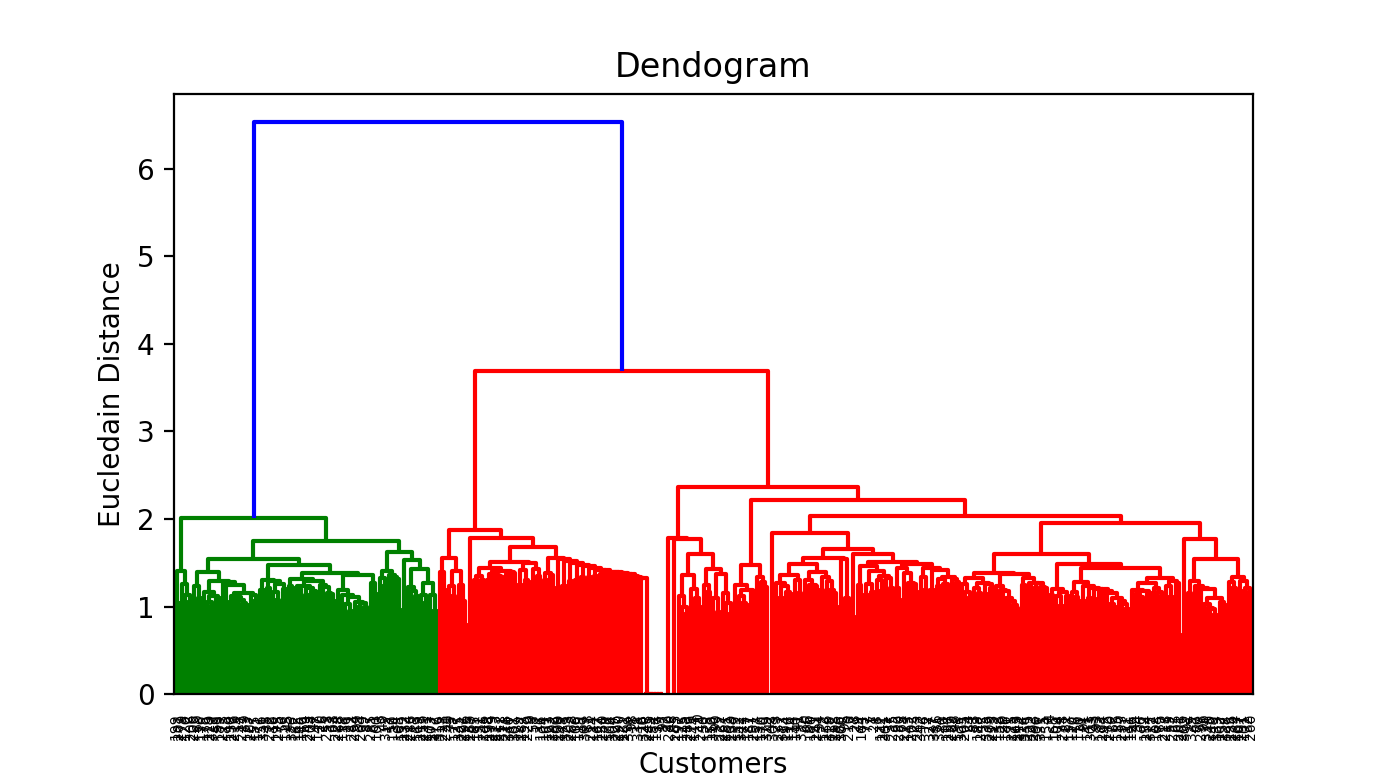

In [562]:
# build hierarchical cluster
%matplotlib notebook
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

dendogram = sch.dendrogram(sch.linkage(df,method='ward'))
plt.title('Dendogram')
plt.xlabel('Customers')
plt.ylabel('Eucledain Distance')
plt.show()

In [ ]:
# -------------- CONSIDER TO REMOVE OUTLIERS FOR THE KMEANS CLUSTERING?


# -------------- ENRICH THE DATA SET
#     MORE FIRMS
#     LARGER MINIMUM SCRAPE


# -------------- BUILD CLASSICATION ENGINE
#     E.G. INFRASTRUCTURE, BI&A
#     





In [700]:
# define list of stopwords (iterate until good result)
# ------- I already exclude max. and min. 
# ------- This creates a list that can be used to develop stop words list

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# count the terms in each document
cv=CountVectorizer(max_df=0.85,
                    min_df=2)
word_count_vector=cv.fit_transform(docs)

df2 = pd.DataFrame(word_count_vector.toarray(), 
                  index=corpus['firm'], 
                  columns=tfidf_vectorizer.get_feature_names()
                 )

term_frequency = pd.DataFrame()
term_frequency = df2.sum(axis=0, skipna=True)
destination_path = '/Users/thorhauberg/Dropbox/Analyse af virksomheder/Resources/StopWordsAnalysis.csv'

term_frequency.to_csv(destination_path, header=True)

#print(term_frequency.loc[0][0])

#with open (destination_path, 'w') as f:
#    for term in term_frequency:
#        f.write(str(term))

ValueError: Shape of passed values is (4550, 84455), indices imply (4550, 27745)